In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt 
import math
from IPython.display import Image

# Company-Level External Effects Analysis

In [7]:
company_df = pd.read_csv('processed_data/company_data.csv')

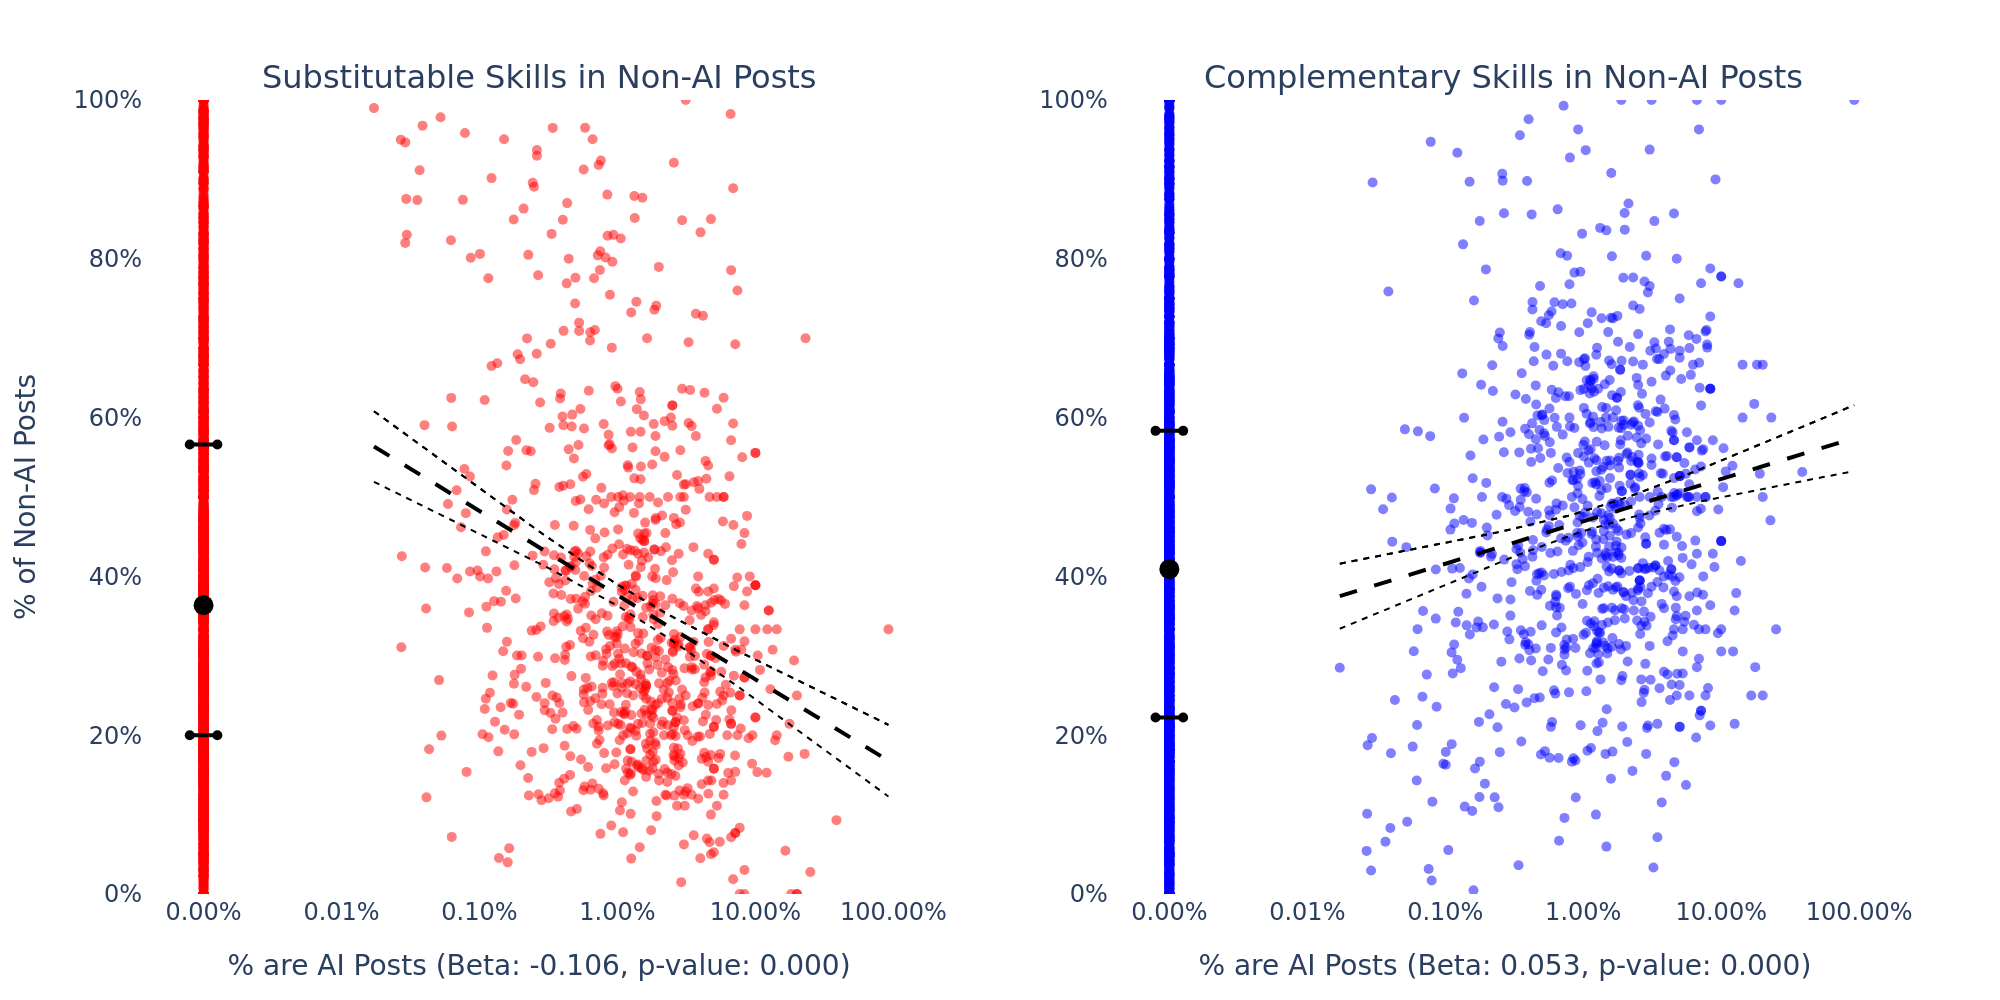

In [8]:
# visualize relationship between ai adoption and non-ai substitutable and complementary skills at the company level
company_df2 = company_df[
    (company_df["YEAR"] == 2023)
].copy()

# add log base 10 column for displaying ai on a log scale
company_df2["LOG_AI"] = np.log10(company_df2["AI"] + 1e-5)

# plot ai vs non-ai substitutable skills and complementary skills in scatter subplots for all companies
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Substitutable Skills in Non-AI Posts",
        "Complementary Skills in Non-AI Posts"
    ],
    shared_xaxes=False
)

for i, col in enumerate(["NONAI_SUBSTITUTE", "NONAI_COMPLEMENT"]):
    # add scatter points for each company
    fig.add_trace(
        go.Scatter(
            x=company_df2["LOG_AI"],
            y=company_df2[col],
            mode='markers',
            marker=dict(color='red' if col == "NONAI_SUBSTITUTE" else 'blue', size=5, opacity=0.5),
            text=company_df2["COMPANY_NAME"],
        ), row=1, col=i+1
    )
    # add interquartile range and median for companies with 0 ai posts
    fig.add_trace(
        go.Scatter(
            x=[-5],
            y=[company_df2[company_df2["AI"] == 0][col].median()],
            marker=dict(color='black', size=10),
        name='Median'
    ),
    row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=[-5.1, -4.9],
            y=[company_df2[company_df2["AI"] == 0][col].quantile(0.25)] * 2,
            marker=dict(color='black', size=5),
            name='IQR'
        ),
        row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=[-5.1, -4.9],
            y=[company_df2[company_df2["AI"] == 0][col].quantile(0.75)] * 2,
            marker=dict(color='black', size=5),
        ),
        row=1, col=i+1
    )

fig.update_layout(
    yaxis_title="% of Non-AI Posts",
    template="plotly_white",
    xaxis_showgrid=False,
    xaxis2_showgrid=False,
    yaxis_showgrid=False,
    yaxis2_showgrid=False,
    showlegend=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    xaxis2_zeroline=False,
    yaxis2_zeroline=False,
    width=1000,
    height=500,
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis=dict(
        tickmode='array',
        tickvals=[-5, -4, -3, -2, -1, 0],
        ticktext=[f'{10**x:.2%}' for x in [-5, -4, -3, -2, -1, 0]],
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1],
        ticktext=[f'{x:.0%}' for x in [0, 0.2, 0.4, 0.6, 0.8, 1]],
        range=[0, 1],
    ),
    xaxis2=dict(
        tickmode='array',
        tickvals=[-5, -4, -3, -2, -1, 0],
        ticktext=[f'{10**x:.2%}' for x in [-5, -4, -3, -2, -1, 0]],
    ),
    yaxis2=dict(
        tickmode='array',
        tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1],
        ticktext=[f'{x:.0%}' for x in [0, 0.2, 0.4, 0.6, 0.8, 1]],
        range=[0, 1],
    )
)

# add line of best fit with confidence intervals
def add_line_of_best_fit(fig, x_col, y_col, row, col):
    
    company_df3 = company_df2[company_df2["AI"] > 0].dropna()
    model = smf.ols(f"{y_col} ~ {x_col}", data=company_df3).fit()
    x_vals = np.linspace(company_df3[x_col].min(), company_df3[x_col].max(), 100)
    y_vals = model.predict(pd.DataFrame({x_col: x_vals}))
    pred = model.get_prediction(pd.DataFrame({x_col: x_vals}))
    pred_summary = pred.summary_frame(alpha=0.05)

    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='lines',
            name='Line of Best Fit',
            line=dict(color='black', width=2, dash='dash'),
            showlegend=False
        ),
        row=row, col=col
    )

    # add confidence intervals
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=pred_summary['mean_ci_lower'],
            mode='lines',
            line=dict(color='black', width=1, dash='dot'),
            showlegend=False
        ),
        row=row, col=col
    )
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=pred_summary['mean_ci_upper'],
            mode='lines',
            line=dict(color='black', width=1, dash='dot'),
            showlegend=False
        ),
        row=row, col=col    
    )
    fig.add_trace(
        go  .Scatter(
            x=x_vals,
            y=pred_summary['mean_ci_upper'],
            mode='lines',
            line=dict(color='black', width=1, dash='dot'),
            showlegend=False
        ),
        row=row, col=col
    )
    
    # add beta coefficient p-value to the plot title
    beta = model.params[x_col]
    p_value = model.pvalues[x_col]
    fig.update_xaxes(
        title_text=f"% are AI Posts (Beta: {beta:.3f}, p-value: {p_value:.3f})",
        row=row, col=col
    )

add_line_of_best_fit(fig, "LOG_AI", "NONAI_SUBSTITUTE", 1, 1)
add_line_of_best_fit(fig, "LOG_AI", "NONAI_COMPLEMENT", 1, 2)

fig.write_image("figures/company_ai_subcomp_scatter.png", scale=2, width=1000, height=500)
display(Image("figures/company_ai_subcomp_scatter.png"))


In [9]:
company_df3 = company_df[
    company_df["AI"] < company_df["AI"].quantile(0.99) # remove outliers
].dropna()
company_df3["LOG_COUNT"] = np.log1p(company_df3["COUNT"])

model1 = smf.glm("NONAI_SUBSTITUTE ~ LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')
model2 = smf.glm("NONAI_SUBSTITUTE ~ AI_DUMMY + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')
model3 = smf.glm("NONAI_COMPLEMENT ~ LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')
model4 = smf.glm("NONAI_COMPLEMENT ~ AI_DUMMY + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')

def model_results(models, response):
    
    table = summary_col(
        models,
        regressor_order = [
            "AI_DUMMY",
            "AI"
        ],
        stars=True,
        float_format='%0.2f',
        info_dict={
            'N':lambda x: "{0:d}".format(int(x.nobs)),
            'AIC':lambda x: "{:.2f}".format(x.aic)
        }
    )

    if response == "AI_DUMMY":
        print(f"Average Marginal Effect for {response} - Substitute: {model2.get_margeff().summary_frame().loc[response, 'dy/dx']:.4%}")
        print(f"Average Marginal Effect for {response} - Complement: {model4.get_margeff().summary_frame().loc[response, 'dy/dx']:.4%}")
    else:
        print(f"Average Marginal Effect for {response} - Substitute: {model2.get_margeff().summary_frame().loc[response, 'dy/dx'] / 100:.4%}")
        print(f"Average Marginal Effect for {response} - Complement: {model4.get_margeff().summary_frame().loc[response, 'dy/dx'] / 100:.4%}")
    print(table.as_latex())

model_results([model1, model2, model3, model4], "AI_DUMMY")

PatsyError: Error evaluating factor: NameError: name 'AI_DUMMY' is not defined
    NONAI_SUBSTITUTE ~ AI_DUMMY + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)
                       ^^^^^^^^

In [ ]:
model1 = smf.glm("NONAI_SUBSTITUTE ~ LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3[company_df3["AI"]>0], family=sm.families.Binomial()).fit(cov_type='HC0')
model2 = smf.glm("NONAI_SUBSTITUTE ~ AI + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3[company_df3["AI"]>0], family=sm.families.Binomial()).fit(cov_type='HC0')
model3 = smf.glm("NONAI_COMPLEMENT ~ LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3[company_df3["AI"]>0], family=sm.families.Binomial()).fit(cov_type='HC0')
model4 = smf.glm("NONAI_COMPLEMENT ~ AI + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3[company_df3["AI"]>0], family=sm.families.Binomial()).fit(cov_type='HC0')

model_results([model1, model2, model3, model4], "AI")

Average Marginal Effect for AI - Substitute: -1.4668%
Average Marginal Effect for AI - Complement: -0.0170%
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                                                                                                    & NONAI\_SUBSTITUTE I & NONAI\_SUBSTITUTE II & NONAI\_COMPLEMENT I & NONAI\_COMPLEMENT II  \\
\hline
AI                                                                                                  &                     & -6.46***             &                     & -0.07                 \\
                                                                                                    &                     & (0.90)               &                     & (0.69)                \\
Intercept                                                                                           & -0.83***            & -0.51***             & -0.07               & -0.07                 \\
                              

In [ ]:
model1 = smf.glm("NONAI_SUBSTITUTE ~ LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')
model2 = smf.glm("NONAI_SUBSTITUTE ~ AI + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')
model3 = smf.glm("NONAI_COMPLEMENT ~ LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')
model4 = smf.glm("NONAI_COMPLEMENT ~ AI + LOG_COUNT + C(YEAR) + C(NAICS_2022_2_NAME)", data=company_df3, family=sm.families.Binomial()).fit(cov_type='HC0')

model_results([model1, model2, model3, model4], "AI")

Average Marginal Effect for AI - Substitute: -2.0053%
Average Marginal Effect for AI - Complement: 1.3619%
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                                                                                                    & NONAI\_SUBSTITUTE I & NONAI\_SUBSTITUTE II & NONAI\_COMPLEMENT I & NONAI\_COMPLEMENT II  \\
\hline
AI                                                                                                  &                     & -8.68***             &                     & 5.67***               \\
                                                                                                    &                     & (0.64)               &                     & (0.50)                \\
Intercept                                                                                           & -0.29***            & -0.31***             & -0.55***            & -0.54***              \\
                               